In [1]:
from diffusers import ControlNetModel, StableDiffusionXLControlNetPipeline, AutoencoderKL
from diffusers.utils import load_image
from PIL import Image
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt


/home/tlips/.conda/envs/dsd/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

controlnet = ControlNetModel.from_pretrained(
    "diffusers/controlnet-canny-sdxl-1.0-mid",
    torch_dtype=torch.float16
)
vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
pipe = StableDiffusionXLControlNetPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    controlnet=controlnet,
    vae=vae,
    torch_dtype=torch.float16,
)
pipe.enable_model_cpu_offload()



Loading pipeline components...: 100%|██████████| 7/7 [00:37<00:00,  5.38s/it]


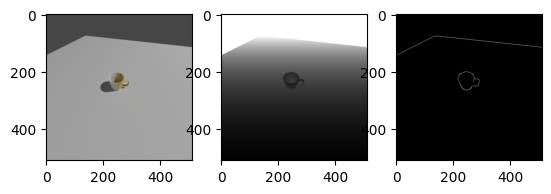

In [10]:

from dsd import DATA_DIR


render_path = DATA_DIR / "renders/mugs/close"
rgb_image = Image.open(render_path / "rgb.png")
rgb_image = load_image(rgb_image)
depth_image = load_image(Image.open(render_path / "depth_image.png"))

image = np.array(depth_image)
image = cv2.Canny(image, 10, 250)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
image = Image.fromarray(image)

# show original image, depth image and cannied depth image
plt.subplot(1, 3, 1)
plt.imshow(rgb_image)
plt.subplot(1, 3, 2)
plt.imshow(depth_image)
plt.subplot(1, 3, 3)
plt.imshow(image)





In [13]:
prompt = "blue mug, photorealistic"
negative_prompt = "low quality, bad quality, sketches"
controlnet_conditioning_scale = 0.8

images = pipe(
    prompt, negative_prompt=negative_prompt, image=image, controlnet_conditioning_scale=controlnet_conditioning_scale,num_images_per_prompt=4
).images

100%|██████████| 50/50 [00:14<00:00,  3.34it/s]


Text(0.5, 1.0, 'Prompted 4')

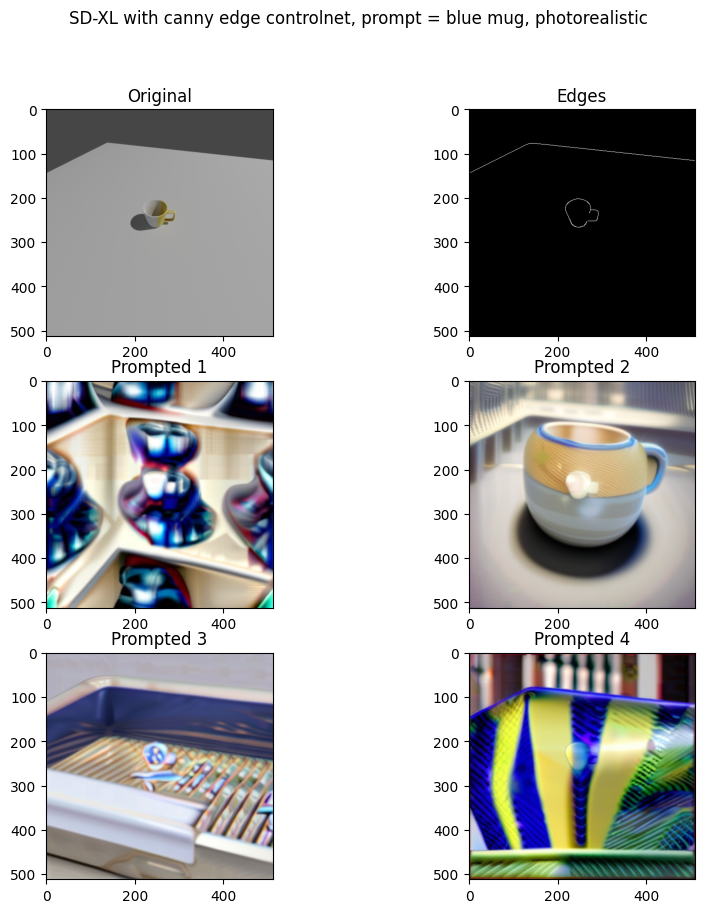

: 

In [14]:
## show results next to the original image and the cannied image
import matplotlib.pyplot as plt
fig, axs = plt.subplots(3, 2, figsize=(10, 10))
# set the title
fig.suptitle(f"SD-XL with canny edge controlnet, prompt = {prompt}")
axs[0, 0].imshow(rgb_image)
axs[0, 0].set_title("Original")
axs[0, 1].imshow(image)
axs[0, 1].set_title("Edges")
axs[1, 0].imshow(images[0])
axs[1, 0].set_title("Prompted 1")
axs[1, 1].imshow(images[1])
axs[1, 1].set_title("Prompted 2")
axs[2, 0].imshow(images[2])
axs[2, 0].set_title("Prompted 3")
axs[2, 1].imshow(images[3])
axs[2, 1].set_title("Prompted 4")